In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import copy
from six import StringIO
from IPython.display import Image  
import pydotplus
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (0) EDA & DATA CLEANING

In [ ]:
# TOBACCO PRODUCTION
tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")
print(tobacco_production.head())
print(tobacco_production.info())
print(tobacco_production.describe())

  Country or Area  Year         Unit        Value Value Footnotes
0         Albania  2006  Metric tons   546.600000             NaN
1         Albania  2006     Mil. USD     1.324113             NaN
2         Albania  2005  Metric tons  1878.500000             NaN
3         Albania  2005     Mil. USD     4.844285             NaN
4         Albania  2004  Metric tons   751.900000             NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  1208 non-null   object 
 1   Year             1208 non-null   int64  
 2   Unit             1208 non-null   object 
 3   Value            1208 non-null   float64
 4   Value Footnotes  187 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 47.3+ KB
None
              Year         Value
count  1208.000000  1.208000e+03
mean   2005.293874  1.403498e+04
std      

In [ ]:
print("# of Unique Countries:", len(np.unique(tobacco_production["Country or Area"])))
print("Unique Value Footnotes:", list(set(tobacco_production["Value Footnotes"])))
print("Unique Units:", np.unique(tobacco_production["Unit"]))

# of Unique Countries: 79
Unique Value Footnotes: [nan, '16', '4', '7', '12', '14', '6', '13,14', '17', '8', '5', '15', '3', '10', '2', '9', '1', '11']
Unique Units: ['Metric tons' 'Mil. USD']


In [ ]:
tobacco_production = tobacco_production.drop("Value Footnotes", axis=1)
tobacco_production = tobacco_production[tobacco_production["Unit"] == "Metric tons"]

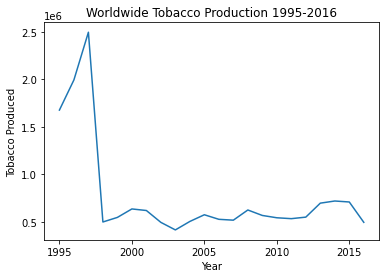

In [ ]:
tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")
tobacco_production = tobacco_production[tobacco_production["Unit"] == "Metric tons"]
tobacco_production.groupby(["Year"])["Value"].agg("sum").plot(ylabel="Tobacco Produced", 
                                                              title="Worldwide Tobacco Production 1995-2016")
plt.show()

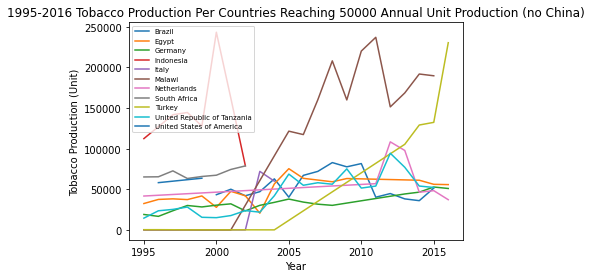

In [ ]:
# Tobacco production has increased/decreased exponentially for some countries. (excluded china, which is leader)

tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")

#df = tobacco_production # with china
df = tobacco_production[tobacco_production["Country or Area"] != "China"] # without china
top_100000 = np.unique(df[df["Value"] > 50000]["Country or Area"])
df = df[np.isin(df["Country or Area"], top_100000)]
df = df.groupby(["Year", "Country or Area"])["Value"].agg("sum")
df = df.reset_index()
df.set_index('Year', inplace=True)
df.groupby('Country or Area')['Value'].plot(legend=True, 
                                            ylabel="Tobacco Production (Unit)", 
                                            title="1995-2016 Tobacco Production Per Countries Reaching 50000 Annual Unit Production (no China)")
plt.legend(loc=2, prop={'size': 7})
plt.show()

In [ ]:
# TOBACCO CONSUMPTION WORLDWIDE

tobacco_use_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
print(tobacco_use_ww.head())
print(tobacco_use_ww.info())
print(tobacco_use_ww.describe())

  ParentLocationCode         ParentLocation  ...  Gender Value
0               SEAR        South-East Asia  ...  Female   0.0
1                EUR                 Europe  ...  Female   0.2
2                AFR                 Africa  ...  Female   0.3
3                EMR  Eastern Mediterranean  ...  Female   0.4
4                AFR                 Africa  ...  Female   0.4

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023 entries, 0 to 4022
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ParentLocationCode   4023 non-null   object 
 1   ParentLocation       4023 non-null   object 
 2   SpatialDimValueCode  4023 non-null   object 
 3   Location             4023 non-null   object 
 4   Year                 4023 non-null   int64  
 5   Gender               4023 non-null   object 
 6   Value                4023 non-null   float64
dtypes: float64(1), int64(1), object(5)
memo

In [ ]:
print("Unique ParentLocations:", len(np.unique(tobacco_use_ww["ParentLocation"])))
print("Unique Countries:", len(np.unique(tobacco_use_ww["Location"])))
tobacco_use_ww = tobacco_use_ww.drop(["ParentLocationCode", "SpatialDimValueCode"], axis=1)
tobacco_use_ww = tobacco_use_ww[tobacco_use_ww["Gender"] == "Both Sexes"]

Unique ParentLocations: 6
Unique Countries: 149


Location
Nepal                              -11.5
Lao People's Democratic Republic    -9.2
Sweden                              -8.8
Cambodia                            -8.8
Norway                              -8.4
Argentina                           -8.3
India                               -7.8
Timor-Leste                         -7.4
Nauru                               -7.4
Cuba                                -7.3
Name: Value, dtype: float64
Location
Oman                   0.0
France                 0.1
Egypt                  0.2
Slovakia               0.4
Republic of Moldova    0.5
Niger                  0.5
Croatia                1.0
Portugal               1.5
Congo                  2.6
Lesotho                3.7
Name: Value, dtype: float64


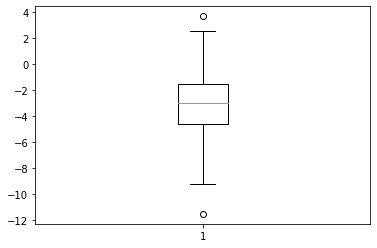

In [ ]:
# Percent population tobacco consumption 2018 - Percent population tobacco consumption 2000
tobacco_consumption = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
np.unique(tobacco_consumption["Year"])
tobacco_consumption = tobacco_consumption[tobacco_consumption["Gender"]=="Both sexes"]
tobacco_consumption = tobacco_consumption[np.isin(tobacco_consumption["Year"], [2010, 2018])]
tobacco_consumption = tobacco_consumption.groupby(["Location"])["Value"].agg(lambda x: (x.iat[0]-x.iat[-1]))
print(tobacco_consumption.sort_values().head(10))
print(tobacco_consumption.sort_values().tail(10))

plt.boxplot(tobacco_consumption)
plt.show()

In [ ]:
# TOBACCO CONSUMPTION - United States
tobacco_use_us = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_us.csv")
print(tobacco_use_us.iloc[0,:])
print(tobacco_use_us.info())
print(tobacco_use_us.describe())
print(np.unique(tobacco_use_us["Question"]))
'''
drop: Locationabbr, Data_value_type, data_Value_Footnote, LocationID, BreakoutID, BreakOutcategoryID, QuestionID, ResponseID, GeoLocation, +?
'''

Year                                                                  2019
Locationabbr                                                            KS
Locationdesc                                                        Kansas
Topic                                                    Smokeless Tobacco
Question                 Do you currently use chewing tobacco, snuff, o...
Response                                                         Every day
Break_Out                                                            25-34
Break_Out_Category                                               Age Group
Sample_Size                                                             52
Data_value                                                            4.31
Confidence_limit_Low                                                  3.02
Confidence_limit_High                                                  5.6
Data_value_unit                                                          %
Data_value_type          

'\ndrop: Locationabbr, Data_value_type, data_Value_Footnote, LocationID, BreakoutID, BreakOutcategoryID, QuestionID, ResponseID, GeoLocation, +?\n'

In [ ]:
countries = tobacco_production["Country or Area"].values
countries = list(dict.fromkeys(countries))

production = []
for i in range(len(countries)):  
    temp = pd.Series.sort_index(tobacco_production[(tobacco_production["Country or Area"] == countries[i])\
                              & (tobacco_production["Unit"] == "Metric tons")].set_index("Year")["Value"])
    rel_change = pd.Series((np.array(temp[1:])-np.array(temp[:-1]))/np.array(temp[:-1])*100,temp.index[1:])
    production.append(rel_change)
p = pd.Series(production,countries)

avg_p = []
for i in p:
    avg_p.append(i.mean())
avg_p = pd.Series(avg_p,countries)

locs = tobacco_use_ww["Location"].values
locs = list(dict.fromkeys(locs))

consumption = []
for i in range(len(locs)):
    test = pd.Series.sort_index(tobacco_use_ww[(tobacco_use_ww["Location"] == locs[i])\
                         & (tobacco_use_ww["Gender"] == "Both sexes")].set_index("Year")["Value"])
    change = pd.Series(np.array(test[1:])-np.array(test[:-1]),test.index[1:])
    consumption.append(change)
c = pd.Series(consumption,locs)

avg_c = []
for i in c:
    avg_c.append(i.mean())
avg_c = pd.Series(avg_c,locs)

places = []
pmc = [] #production minus consumption
for i in range(len(p)):
    for j in range(len(c)):
        if p.index[i] == c.index[j]:
            places.append(p.index[i])
            year = []
            diff = []
            for k in range(len(p[i])):
                for l in range(len(c[j])):
                    if p[i].index[k] == c[j].index[l]:
                        year.append(p[i].index[k])
                        diff.append(p[i][p[i].index[k]]-c[j][c[j].index[l]])
            pmc.append(pd.Series(diff,year,dtype=object))
d = pd.Series(pmc,places)
    
avg_d = []
for i in d:
    avg_d.append(i.mean())
avg_d = pd.Series(avg_d,places)

avg_p_per_country = []
for i in range(len(countries)):  
    temp = pd.Series.sort_index(tobacco_production[(tobacco_production["Country or Area"] == countries[i])\
                              & (tobacco_production["Unit"] == "Metric tons")].set_index("Year")["Value"])
    avg = temp.mean()
    avg_p_per_country.append(avg)
avg_production = pd.Series(avg_p_per_country,countries)

avg_c_per_country = []
for i in range(len(locs)):
    temp = pd.Series.sort_index(tobacco_use_ww[(tobacco_use_ww["Location"] == locs[i])\
                         & (tobacco_use_ww["Gender"] == "Both sexes")].set_index("Year")["Value"])
    avg = temp.mean()
    avg_c_per_country.append(avg)
avg_consumption = pd.Series(avg_c_per_country,locs)

pc_scatter = pd.DataFrame(columns=['Country','Production','Consumption'])
pc_scatter["Country"] = places
pc_scatter = pc_scatter.set_index("Country")

for i in range(len(p)):
    for j in range(len(c)):
        if avg_production.index[i] == avg_consumption.index[j]:
            pc_scatter["Production"][avg_production.index[i]] = avg_production[i]
            pc_scatter["Consumption"][avg_consumption.index[j]] = avg_consumption[j]      
pc_scatter = pc_scatter.sort_values("Production",ascending=False)

fig,ax = plt.subplots(figsize=(15,11))
ax.scatter(pc_scatter["Production"].drop(labels=["China"]),pc_scatter["Consumption"].drop(labels=["China"]))
#ax.scatter(pc_scatter["Production"],pc_scatter["Consumption"])
for i in range(6):
    ax.annotate(pc_scatter.index[i],(pc_scatter["Production"][i],pc_scatter["Consumption"][i]))
ax.set_xlabel("Production [Metric Tons]")
ax.set_ylabel("Consumption [% Population, Both Sexes]")
plt.show()

In [ ]:
stop_smoking = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking.csv")
print(stop_smoking.head())
print(stop_smoking.info())
print(stop_smoking.describe())

      Entity Code  ...  EnforceBansTobaccoAd  HelpToQuit
0    Algeria  DZA  ...                     4           3
1    Algeria  DZA  ...                     4           4
2  Argentina  ARG  ...                     4           4
3  Argentina  ARG  ...                     4           5
4    Armenia  ARM  ...                     2           4

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Entity                       774 non-null    object 
 1   Code                         774 non-null    object 
 2   Year                         774 non-null    int64  
 3   AvgCigarettePriceDollars     208 non-null    float64
 4   AvgTaxesAsPctCigarettePrice  209 non-null    float64
 5   EnforceBansTobaccoAd         774 non-null    int64  
 6   HelpToQuit                   774 non-null    int64  
dtypes: fl

In [ ]:
print("Unique Countries:", len(np.unique(stop_smoking["Entity"])))
print("Unique Years:", np.unique(stop_smoking["Year"]))
stop_smoking = stop_smoking.drop(["AvgCigarettePriceDollars", "AvgTaxesAsPctCigarettePrice"], axis=1)

Unique Countries: 194
Unique Years: [2007 2010 2012 2014]


In [ ]:
stop_smoking_extended = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking_extended.csv")
print(stop_smoking_extended.head())
print(stop_smoking_extended.info())
print(stop_smoking_extended.describe())

       Country  Year  ...  Raise taxes on tobacco  Anti-tobacco mass media campaigns
0  Afghanistan  2018  ...                       2                                  2
1  Afghanistan  2016  ...                       2                                  2
2  Afghanistan  2014  ...                       2                                  2
3  Afghanistan  2012  ...                       2                                  2
4  Afghanistan  2010  ...                       2                                  1

[5 rows x 9 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Country                              1365 non-null   object
 1   Year                                 1365 non-null   int64 
 2   Monitor                              1365 non-null   int64 
 3   Protect from tobacco smoke      

In [ ]:
print("Unique Countries:", len(np.unique(stop_smoking_extended["Country"])))
print("Unique Years:", np.unique(stop_smoking_extended["Year"]))

Unique Countries: 195
Unique Years: [2007 2008 2010 2012 2014 2016 2018]


In [ ]:
tobacco_tax_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_tax_ww.csv")
tobacco_tax_ww = tobacco_tax_ww[["Location", "Period", "Value"]]
print(tobacco_tax_ww.info())
print(tobacco_tax_ww.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Location  1170 non-null   object
 1   Period    1170 non-null   int64 
 2   Value     1170 non-null   object
dtypes: int64(1), object(2)
memory usage: 27.5+ KB
None
            Period
count  1170.000000
mean   2013.000000
std       3.417111
min    2008.000000
25%    2010.000000
50%    2013.000000
75%    2016.000000
max    2018.000000


In [ ]:
# Excise Tax Rate
excise_tax=pd.read_csv("drive/MyDrive/central-datathon-files/Excise_tax.csv")
excise_tax=excise_tax.rename(columns={'LocationDesc':'Locationdesc'})
print(excise_tax.head())
print(excise_tax.info())
print(excise_tax.describe())

     Locationdesc      Data Range  ProvisionValue
0         Alabama  $0.50 to $0.99           0.675
1          Alaska  $2.00 to $3.99           2.000
2  American Samoa  $4.00 to $6.00           6.000
3         Arizona  $2.00 to $3.99           2.000
4        Arkansas  $1.00 to $1.49           1.150
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Locationdesc    58 non-null     object 
 1   Data Range      58 non-null     object 
 2   ProvisionValue  58 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB
None
       ProvisionValue
count       58.000000
mean         2.136793
std          1.416267
min          0.170000
25%          1.085000
50%          1.870000
75%          3.036250
max          6.000000


In [ ]:
# (1) tobacco use dataset
tobacco_use_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
tobacco_use_ww = tobacco_use_ww[tobacco_use_ww["Gender"] == "Both sexes"]
tobacco_use_ww = tobacco_use_ww[["Location", "Year", "Value", "ParentLocation"]]
tobacco_use_ww = tobacco_use_ww.rename(columns={"Year":"Period", "Value":"Usage"})

# (2) most sold brand of cig tax dataset
tobacco_tax_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_tax_ww.csv")

# (3) tobacco regulation dataset
stop_smoking_extended = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking_extended.csv")
stop_smoking_extended = stop_smoking_extended.drop(["Raise taxes on tobacco"], axis=1)

# (4) merging datasets
tobacco_tax_ww = tobacco_tax_ww[["Location", "Period", "Value"]]
tobacco_tax_ww = tobacco_tax_ww.rename(columns={"Value":"Price"})
stop_smoking_extended = stop_smoking_extended.rename(columns={"Country":"Location", "Year":"Period"})
new_df = pd.merge(stop_smoking_extended,tobacco_tax_ww, on=['Location','Period'])
new_df = pd.merge(new_df, tobacco_use_ww, on=['Location','Period'])

for i, r in new_df.loc[(new_df["Anti-tobacco mass media campaigns"] == "Data not available"), :].iterrows(): # iterate through data not available rows
  non_NA_df = new_df[new_df["Anti-tobacco mass media campaigns"] != "Data not available"][["Location", "Period", "Anti-tobacco mass media campaigns"]] # rows without DNA error so we can average them
  non_NA_df["Anti-tobacco mass media campaigns"] = pd.to_numeric(non_NA_df["Anti-tobacco mass media campaigns"]) # turn ATMMC to continuous integers for averaging
  means = non_NA_df.groupby(["Location"]).mean().reset_index() # mean value of ATMMC of each location in all the years
  new_df.loc[(new_df.index == i),"Anti-tobacco mass media campaigns"] = str(int(means[means["Location"] == r["Location"]]["Anti-tobacco mass media campaigns"]))

for i, r in new_df[new_df["Price"].isin(["Data not available", "Not applicable"])].iterrows(): # iterate through data not available rows
  non_NA_df = new_df[~new_df["Price"].isin(["Data not available", "Not applicable"])][["Location", "Period", "Price"]] # rows without DNA error so we can average them
  non_NA_df["Price"] = pd.to_numeric(non_NA_df["Price"]) # turn ATMMC to continuous integers for averaging
  means = non_NA_df.groupby(["Location"]).mean().reset_index() # mean value of ATMMC of each location in all the years
  try:
    new_df.loc[(new_df.index == i),"Price"] = str(int(means[means["Location"] == r["Location"]]["Price"]))
  except: # empty series in case no tax data exists for any of the years in a given country
    new_df.loc[(new_df.index == i),"Price"] = 0

np.unique(new_df.ParentLocation)
new_df.to_csv("drive/MyDrive/central-datathon-files/tobacco_use_and_legislation_ww.csv")

(1) NAIVE MULTIPLE LINREG ATTEMPT:


In [ ]:
# normalize time and location
# dropped: location, period, parent location
# (Explanatory): MPOWER scores + price
# (Response): Usage as %

from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

X = new_df.drop(["Usage", "Location", "Period", "ParentLocation"], axis=1) 
y = new_df["Usage"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = LinearRegression()
regr.fit(X, y)

print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
print(regr.score(X, y))

Coefficients:  [ 2.11970079  0.36159386 -1.15686765 -1.25643293  0.98791536 -0.29572938
  0.15921392]
Intercept:  13.687304975792136
0.16688923565047875


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


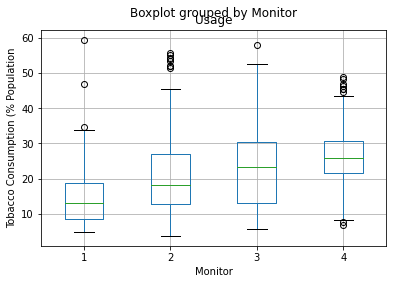

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


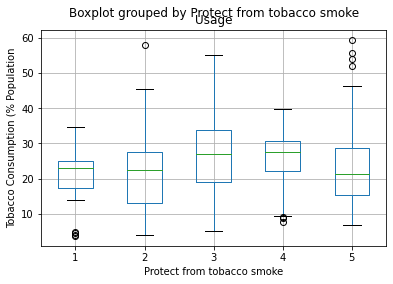

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


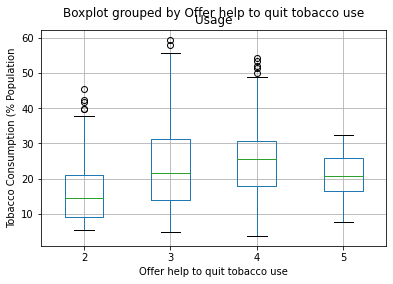

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


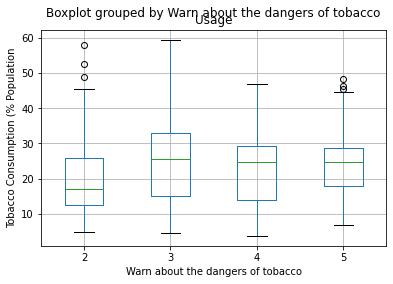

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


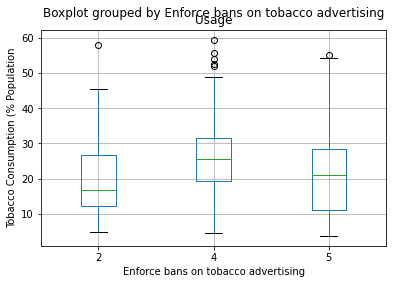

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


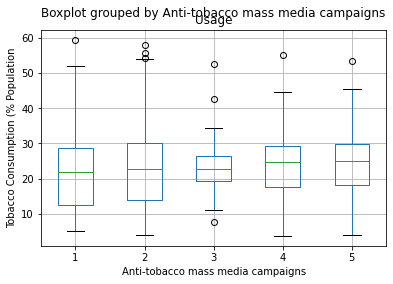

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


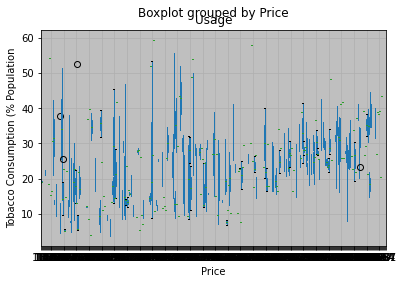

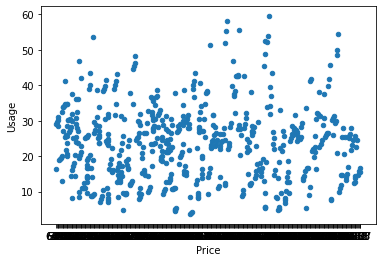

In [ ]:
for column in X.columns:
  new_df.boxplot(column='Usage',by=column)
  plt.ylabel("Tobacco Consumption (% Population")
  plt.show()

new_df.plot("Price", "Usage", kind="scatter")

(2) US TOBACCO TAX VS TOBACCO CONSUMPTION

In [ ]:
use=pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_us.csv")
use=use.set_index('Topic')

Smokeless_Tobacco=use.loc['Smokeless Tobacco']
Smokeless_Tobacco=Smokeless_Tobacco[['Locationdesc','Response','Data_value']]
Smokeless_Tobacco=Smokeless_Tobacco.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Smokeless_Tobacco=Smokeless_Tobacco.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Current_Smoker_Status=use.loc['Current Smoker Status']
Current_Smoker_Status=Current_Smoker_Status[['Locationdesc','Response','Data_value']]
Current_Smoker_Status=Current_Smoker_Status.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Current_Smoker_Status=Current_Smoker_Status.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Smoker_Status=use.loc['Smoker Status']
Smoker_Status=Smoker_Status[['Locationdesc','Response','Data_value']]
Smoker_Status=Smoker_Status.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Smoker_Status=Smoker_Status.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Current_Smoker_Status_tax=pd.merge(Current_Smoker_Status,excise_tax,on='Locationdesc', how='right')
Smoker_Status_tax=pd.merge(Smoker_Status,excise_tax,on='Locationdesc', how='right')
Smokeless_Tobacco_tax=pd.merge(Smokeless_Tobacco,excise_tax,on='Locationdesc', how='right')

print(Current_Smoker_Status_tax.corr())
print(Smokeless_Tobacco_tax.corr())

                      No       Yes  ProvisionValue
No              1.000000 -0.998834        0.423016
Yes            -0.998834  1.000000       -0.420781
ProvisionValue  0.423016 -0.420781        1.000000
                Every day  Not at all  Some days  ProvisionValue
Every day        1.000000   -0.986308   0.806782       -0.558769
Not at all      -0.986308    1.000000  -0.870029        0.581478
Some days        0.806782   -0.870029   1.000000       -0.394003
ProvisionValue  -0.558769    0.581478  -0.394003        1.000000
